## Data Import


In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC, Accuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
df_train = pd.read_csv("dataset/train.csv")
df_test = pd.read_csv("dataset/test.csv")

In [4]:
df_train.head()

,on_thyroxine,lithium,TSH,T3_measured,TT4,T4U,FTI,TBG_measured,target
0,0,0,3.000000,1,121.000000,1.010000,120.000000,0,1
1,0,0,1.500000,1,138.000000,0.980000,141.000000,0,0
2,0,0,5.180223,0,108.590372,0.981514,112.727204,1,0
3,0,0,1.000000,1,73.000000,0.970000,75.000000,0,1
4,1,0,1.600000,1,120.000000,1.100000,109.000000,0,0


## Data Preparation


In [5]:
# split into X_train, y_train, X_test, y_test
X_train = df_train.drop(columns=["target"])
y_train = df_train["target"]
X_test = df_test.drop(columns=["target"])
y_test = df_test["target"]

## Helper Functions


In [6]:
# This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric="accuracy"):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

## Model Building


### Base Model


In [7]:
# create a base LSTM model
def create_model():
    model = Sequential()
    model.add(
        LSTM(
            units=128,
            return_sequences=True,
            input_shape=(X_train.shape[1], 1),
        )
    )
    model.add(Dropout(0.2))
    model.add(LSTM(units=128))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", Precision(), Recall()],
    )
    return model

In [9]:
# initialize model and fit to data
model = create_model()
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test)
)

Epoch 1/100
417/417 [==============================] - 16s 25ms/step - loss: 0.6934 - accuracy: 0.5120 - precision_1: 0.5129 - recall_1: 0.4755 - val_loss: 0.6699 - val_accuracy: 0.6368 - val_precision_1: 0.3518 - val_recall_1: 0.3009
Epoch 2/100
417/417 [==============================] - 12s 28ms/step - loss: 0.6823 - accuracy: 0.5405 - precision_1: 0.5438 - recall_1: 0.5029 - val_loss: 0.7004 - val_accuracy: 0.3944 - val_precision_1: 0.3091 - val_recall_1: 0.8825
Epoch 3/100
417/417 [==============================] - 7s 18ms/step - loss: 0.6796 - accuracy: 0.5439 - precision_1: 0.5452 - recall_1: 0.5292 - val_loss: 0.6692 - val_accuracy: 0.6978 - val_precision_1: 0.4537 - val_recall_1: 0.2106
Epoch 4/100
417/417 [==============================] - 7s 18ms/step - loss: 0.6774 - accuracy: 0.5477 - precision_1: 0.5521 - recall_1: 0.5052 - val_loss: 0.6571 - val_accuracy: 0.6758 - val_precision_1: 0.4033 - val_recall_1: 0.2479
Epoch 5/100
417/417 [==============================] - 8s 19ms

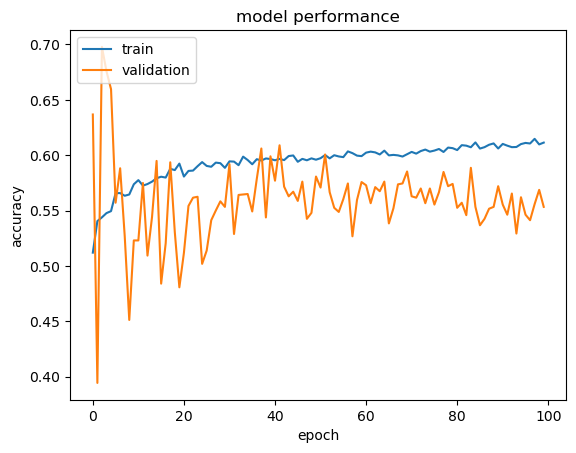

In [10]:
plot_hist(history)

In [11]:
# print confusion matrix and accuracy
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

76/76 [==============================] - 1s 7ms/step
Accuracy:  0.5533416355334163

Confusion Matrix: 
 [[892 819]
 [257 441]]

classification_report: 
               precision    recall  f1-score   support

           0       0.78      0.52      0.62      1711
           1       0.35      0.63      0.45       698

    accuracy                           0.55      2409
   macro avg       0.56      0.58      0.54      2409
weighted avg       0.65      0.55      0.57      2409



In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8, 128)            66560     
                                                                 
 dropout_2 (Dropout)         (None, 8, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


### Tuned Model


In [13]:
def model_builder(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int("units", min_value=32, max_value=256, step=32),
            return_sequences=True,
            input_shape=(X_train.shape[1], 1),
        )
    )
    model.add(Dropout(hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int("units", min_value=32, max_value=256, step=32)))
    model.add(Dropout(hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(
        Dense(1, activation=hp.Choice(
            "dense_activation", ["tanh", "relu", "sigmoid"]))
    )
    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop", "sgd"]),
        loss=hp.Choice("loss", ["binary_crossentropy", "mean_squared_error"]),
        metrics=["accuracy", Precision(), Recall()],
    )
    return model

In [19]:
# RandomSearch to find the best hyperparameters
tuner = kt.RandomSearch(
    model_builder,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=3,
    directory="lstm",
    project_name="lstm",
)

tuner.search(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
)

Trial 20 Complete [00h 00m 43s]
val_accuracy: 0.40321018298467

Best val_accuracy So Far: 0.7121904095013937
Total elapsed time: 00h 08m 54s
INFO:tensorflow:Oracle triggered exit


In [21]:
# get params of best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units': 192,
 'dropout': 0.4,
 'dense_activation': 'relu',
 'optimizer': 'rmsprop',
 'loss': 'binary_crossentropy'}

In [26]:
# get best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 192)            148992    
                                                                 
 dropout (Dropout)           (None, 8, 192)            0         
                                                                 
 lstm_1 (LSTM)               (None, 192)               295680    
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                                                                 
 dense (Dense)               (None, 1)                 193       
                                                                 
Total params: 444,865
Trainable params: 444,865
Non-trainable params: 0
_________________________________________________________________


In [27]:
# build and fit best model
best_model.build(X_train.shape)
history = best_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/100
417/417 [==============================] - 19s 36ms/step - loss: 0.7038 - accuracy: 0.5131 - precision: 0.5143 - recall: 0.4735 - val_loss: 0.6370 - val_accuracy: 0.7107 - val_precision: 0.5047 - val_recall: 0.0774
Epoch 2/100
417/417 [==============================] - 14s 33ms/step - loss: 0.6958 - accuracy: 0.5237 - precision: 0.5261 - recall: 0.4785 - val_loss: 0.6570 - val_accuracy: 0.6941 - val_precision: 0.4325 - val_recall: 0.1791
Epoch 3/100
417/417 [==============================] - 16s 38ms/step - loss: 0.6902 - accuracy: 0.5410 - precision: 0.5443 - recall: 0.5037 - val_loss: 0.6868 - val_accuracy: 0.5259 - val_precision: 0.3287 - val_recall: 0.6103
Epoch 4/100
417/417 [==============================] - 14s 34ms/step - loss: 0.6898 - accuracy: 0.5439 - precision: 0.5470 - recall: 0.5107 - val_loss: 0.6390 - val_accuracy: 0.7123 - val_precision: 0.5116 - val_recall: 0.1576
Epoch 5/100
417/417 [==============================] - 14s 34ms/step - loss: 0.6881 - accura

In [28]:
# print confusion matrix and accuracy for best model
y_pred = best_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

76/76 [==============================] - 4s 12ms/step
Accuracy:  0.6716479867164799

Confusion Matrix: 
 [[1393  318]
 [ 473  225]]

classification_report: 
               precision    recall  f1-score   support

           0       0.75      0.81      0.78      1711
           1       0.41      0.32      0.36       698

    accuracy                           0.67      2409
   macro avg       0.58      0.57      0.57      2409
weighted avg       0.65      0.67      0.66      2409



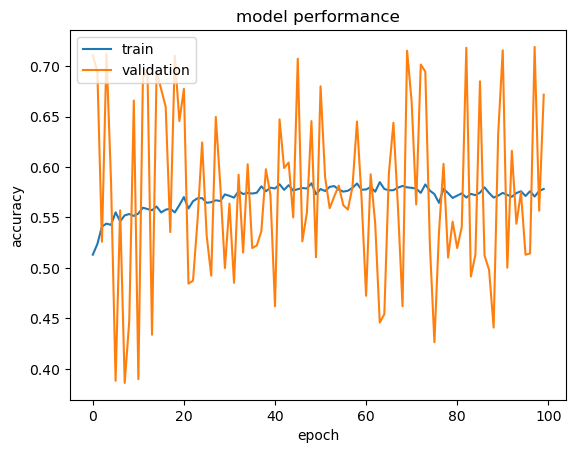

In [29]:
plot_hist(history)